In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Load Data

In [19]:
# Find the latest experiment directory
exp_dir = './experiments'
subdirs = [d for d in os.listdir(exp_dir) if d.startswith('alpha_stats_full')]
latest_subdir = sorted(subdirs)[-1]
output_dir = os.path.join(exp_dir, latest_subdir)

print(f"Loading data from: {output_dir}")

# List all files
files = [f for f in os.listdir(output_dir) if f.endswith('.pt')]
print(f"Found {len(files)} files")
print(f"Files: {files[:5]}..." if len(files) > 5 else f"Files: {files}")

Loading data from: ./experiments/alpha_stats_full_07072820
Found 1 files
Files: ['5a7bb1315542997c3ec97253.pt']


In [20]:
# Load first file to inspect
first_file = os.path.join(output_dir, files[0])
data = torch.load(first_file)

print("Data structure:")
for key, value in data.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {list(value.shape)} ({value.dtype})")
    else:
        print(f"  {key}: {value}")

Data structure:
  alpha_mean: [24, 104, 24, 64] (torch.float32)
  alpha_var: [24, 104, 24, 64] (torch.float32)
  doc2_id: 5a7bb1315542997c3ec97253
  num_doc1_samples: 1000
  max_doc2_len: 104
  n_layer: 24
  nheads: 24
  headdim: 64
  note: alpha_mean shape: [n_layer, max_doc2_len, nheads, headdim]. Only doc2 tokens are included.


## 2. Visualize Alpha Mean - Heatmaps

Visualize how attention weights vary across layers and sequence positions for different heads.

In [21]:
alpha_mean = data['alpha_mean']  # [n_layer, seqlen, nheads, headdim]
alpha_var = data['alpha_var']

n_layer, seqlen, nheads, headdim = alpha_mean.shape
print(f"Shape: [layers={n_layer}, seqlen={seqlen}, heads={nheads}, headdim={headdim}]")

Shape: [layers=24, seqlen=104, heads=24, headdim=64]


In [25]:
# Average across head dimensions to get [n_layer, seqlen, nheads]
alpha_mean_avg = alpha_mean.mean(dim=-1).numpy()  # [n_layer, seqlen, nheads]

# Use all heads instead of random selection
all_heads = list(range(nheads))
print(f"Visualizing all {nheads} heads")

Visualizing all 24 heads


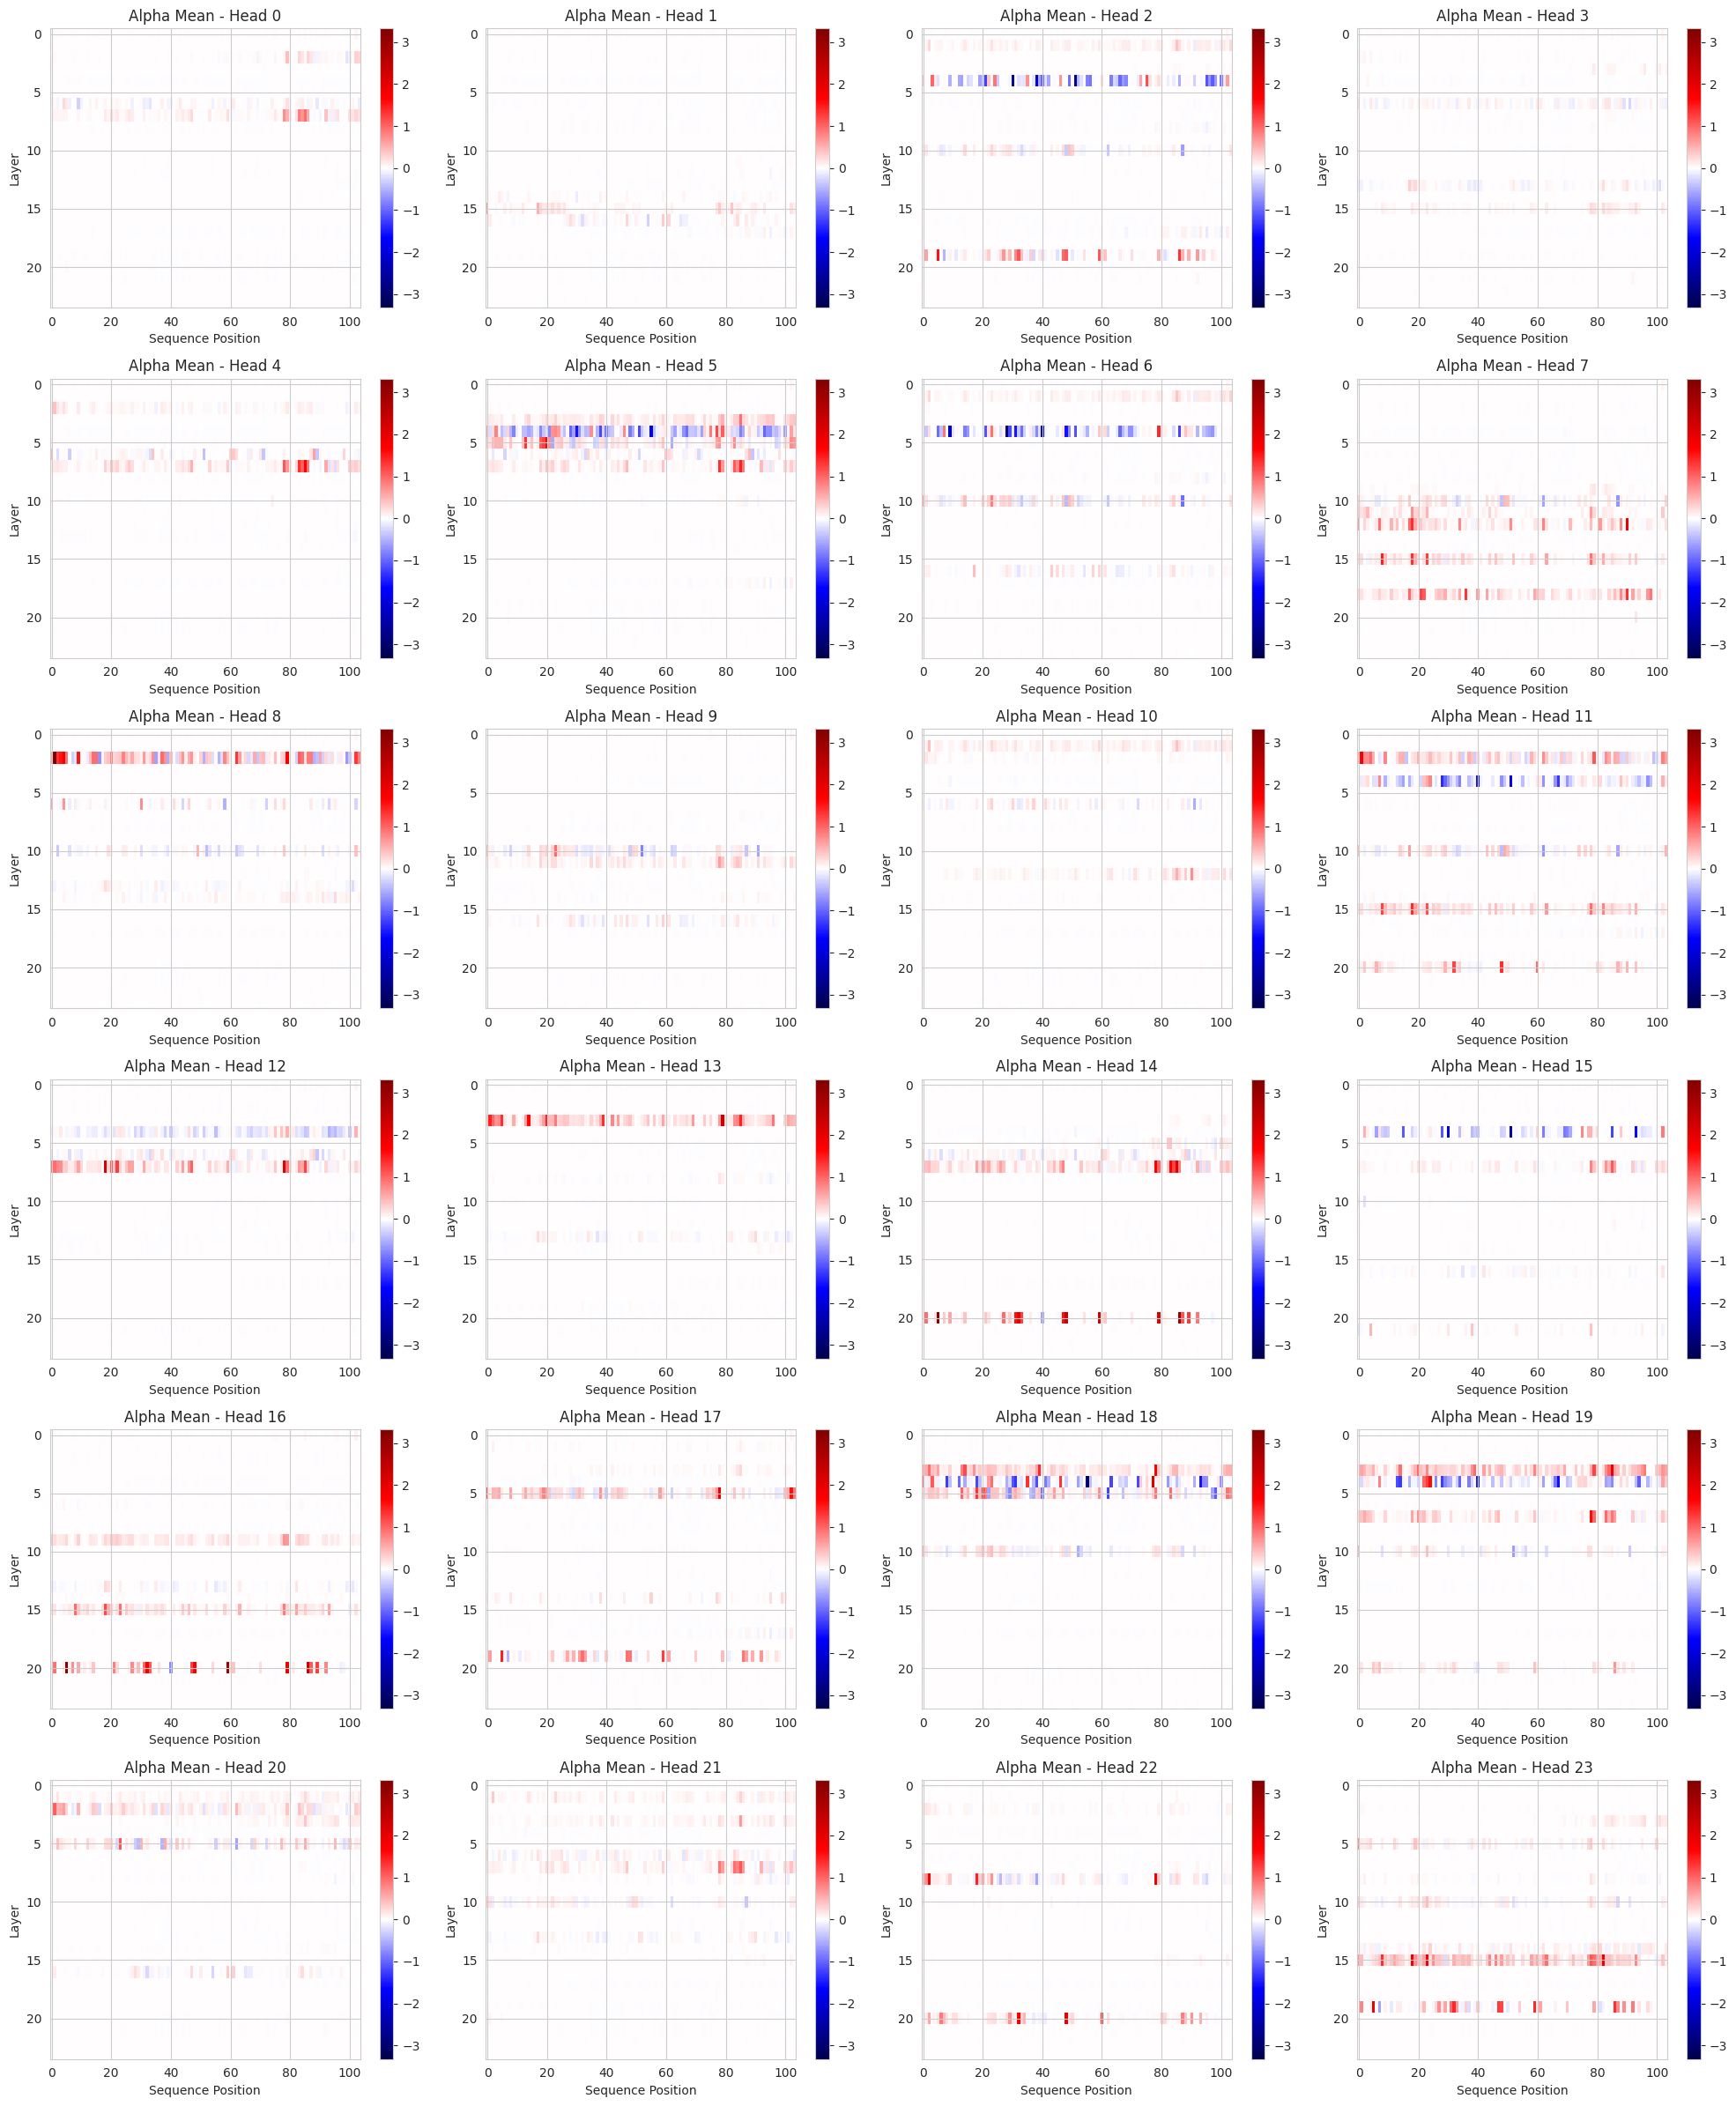

Saved: ./experiments/alpha_stats_full_07072820_alpha_mean_heatmaps.png


In [27]:
# Plot heatmaps for all heads (4 per row)
from matplotlib.colors import TwoSlopeNorm

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Find global min/max and create symmetric scale around 0
vmax = max(abs(alpha_mean_avg.min()), abs(alpha_mean_avg.max()))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_mean_avg[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='seismic', 
                                interpolation='nearest', norm=norm)
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha Mean - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_mean_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_mean_heatmaps.png")

In [ ]:
# Plot RMS heatmaps for all heads (4 per row)
# RMS (Root Mean Square) over headdim dimension
alpha_mean_rms = torch.sqrt((alpha_mean ** 2).mean(dim=-1)).numpy()  # [n_layer, seqlen, nheads]

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Find global min/max for consistent color scale
vmin_rms = alpha_mean_rms.min()
vmax_rms = alpha_mean_rms.max()

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_mean_rms[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='viridis', 
                                interpolation='nearest', vmin=vmin_rms, vmax=vmax_rms)
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha RMS - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_rms_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_rms_heatmaps.png")

## 3. Visualize Alpha Mean - Line Plots

Plot how attention weights change across sequence positions for selected layers.

In [9]:
# Select specific layers to visualize
if n_layer >= 24:
    selected_layers = [0, 5, 11, 17, 23]  # Early, middle, late
elif n_layer >= 12:
    selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]
else:
    selected_layers = [0, n_layer//2, n_layer-1]

print(f"Visualizing layers: {selected_layers}")

Visualizing layers: [0, 5, 11, 17, 23]


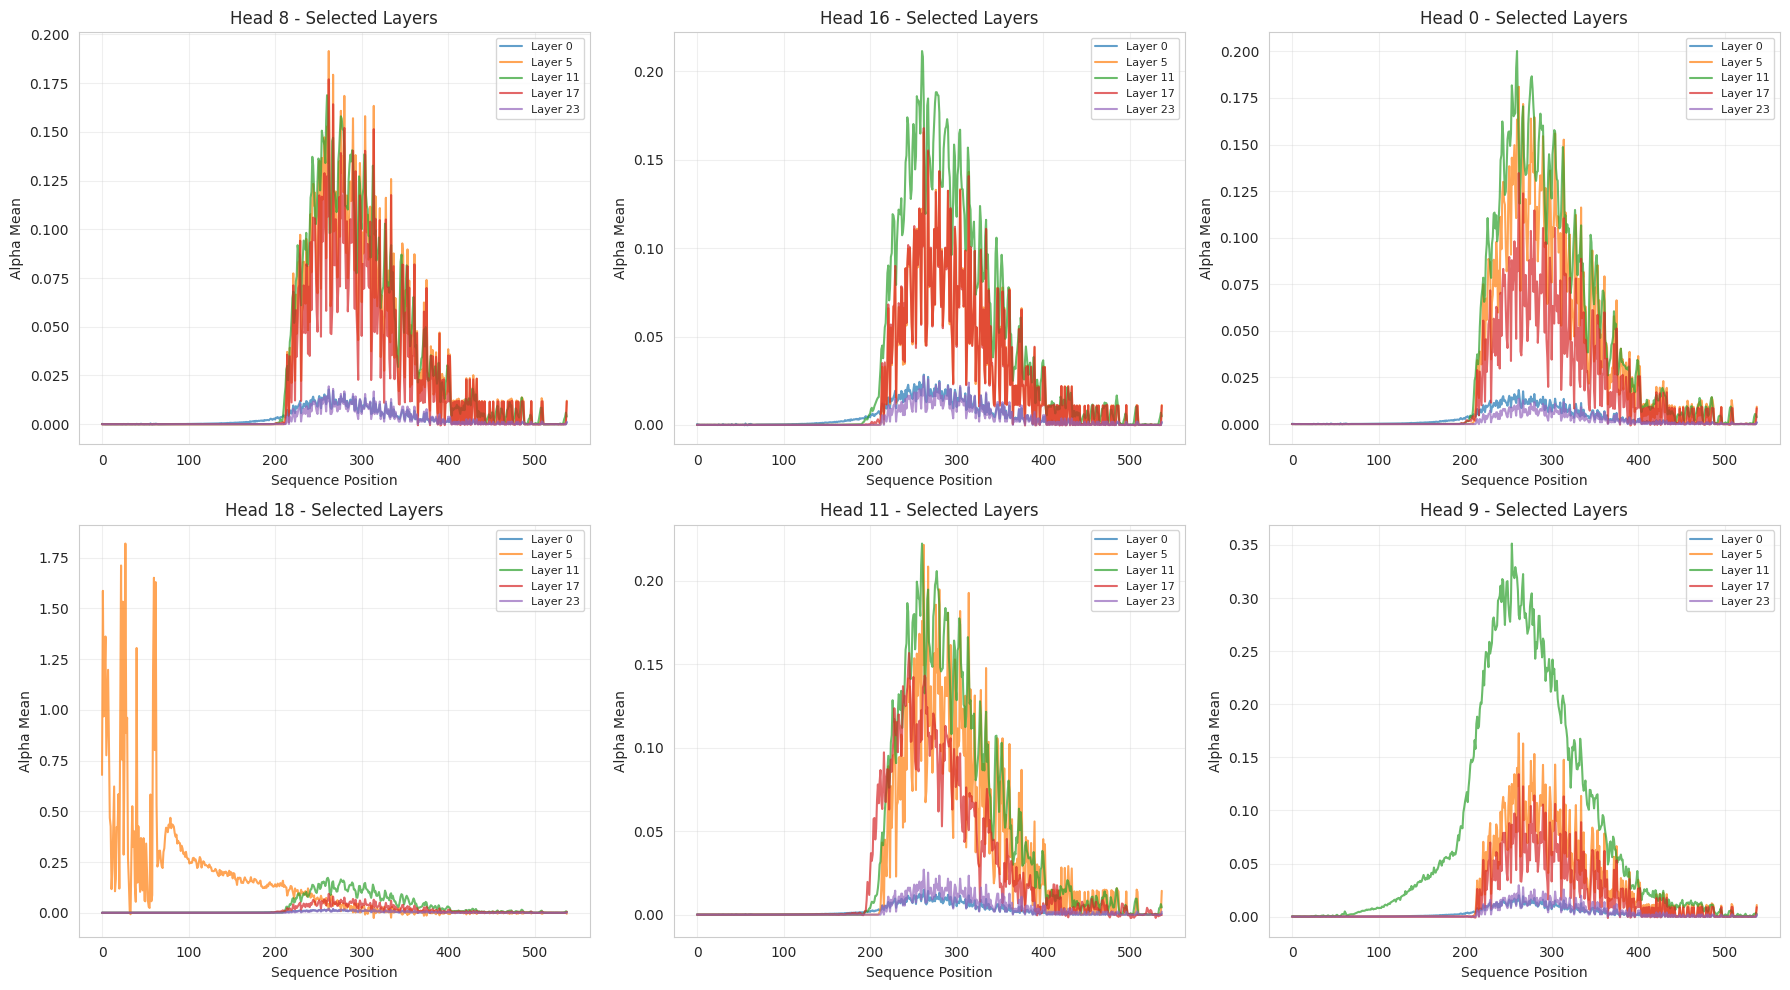

Saved: ./experiments/alpha_stats_full_05120827_alpha_mean_lines.png


In [10]:
# Plot line plots for selected heads
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, head_idx in enumerate(selected_heads):
    for layer in selected_layers:
        # Get data for this head and layer: [seqlen]
        layer_data = alpha_mean_avg[layer, :, head_idx]
        axes[idx].plot(layer_data, label=f'Layer {layer}', alpha=0.7)
    
    axes[idx].set_xlabel('Sequence Position')
    axes[idx].set_ylabel('Alpha Mean')
    axes[idx].set_title(f'Head {head_idx} - Selected Layers')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_mean_lines.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_mean_lines.png")

## 4. Visualize Alpha Variance

Variance shows how consistent the attention patterns are across different doc1 samples.

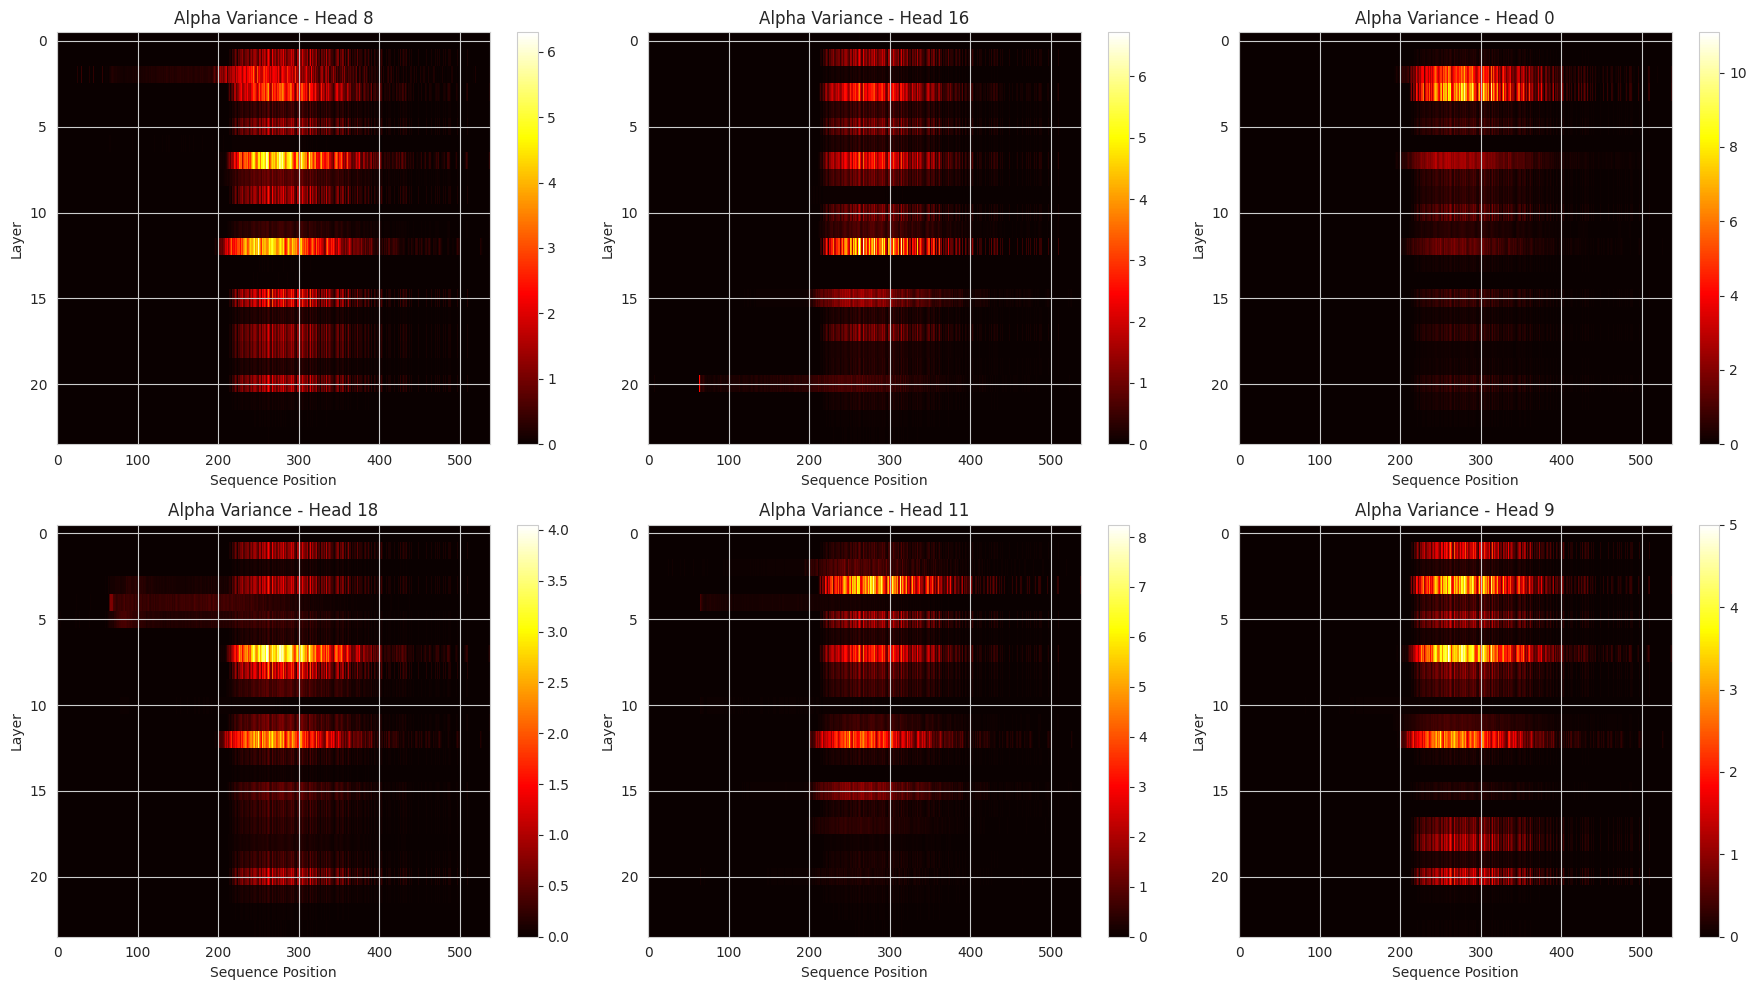

Saved: ./experiments/alpha_stats_full_05120827_alpha_var_heatmaps.png


In [11]:
# Average variance across head dimensions
alpha_var_avg = alpha_var.mean(dim=-1).numpy()  # [n_layer, seqlen, nheads]

# Plot variance heatmaps
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, head_idx in enumerate(selected_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_var_avg[:, :, head_idx]
    
    im = axes[idx].imshow(head_data, aspect='auto', cmap='hot', interpolation='nearest')
    axes[idx].set_xlabel('Sequence Position')
    axes[idx].set_ylabel('Layer')
    axes[idx].set_title(f'Alpha Variance - Head {head_idx}')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_var_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_var_heatmaps.png")

## 5. Analyze Attention Patterns

Analyze which tokens receive the most attention from the last token.

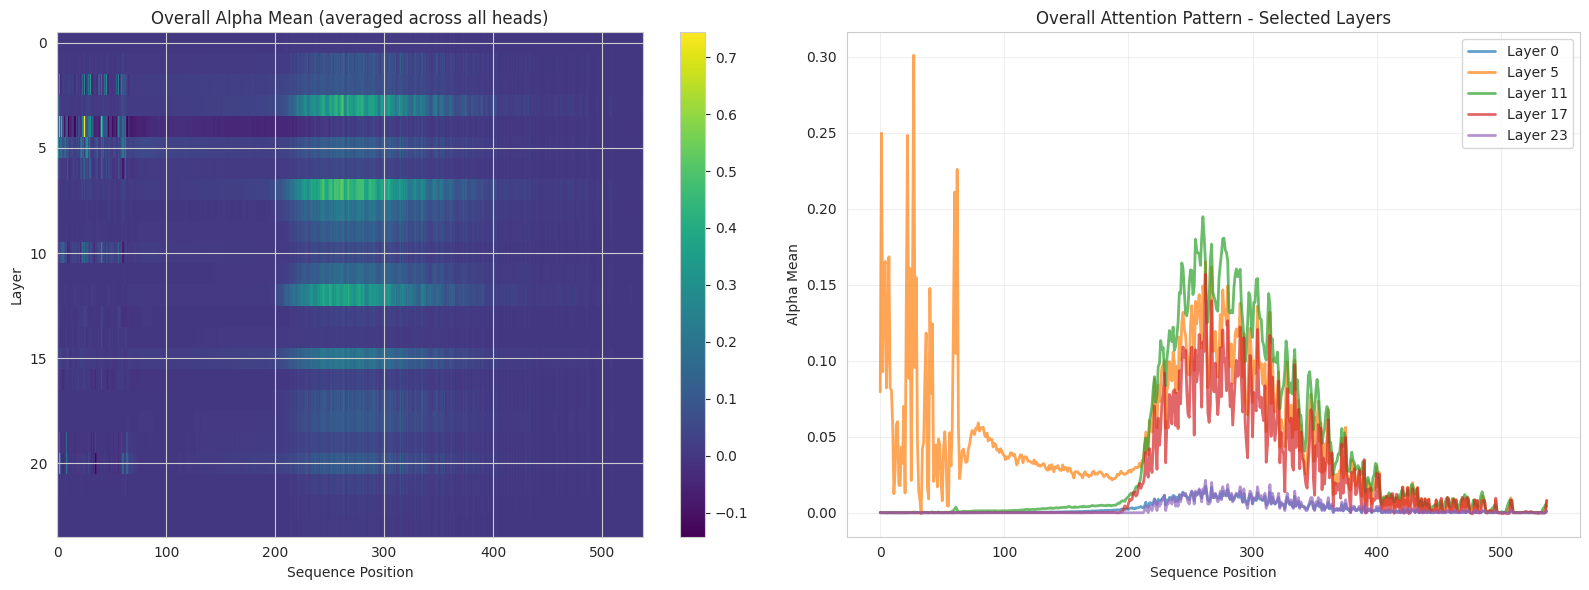

Saved: ./experiments/alpha_stats_full_05120827_overall_pattern.png


In [12]:
# Average across all heads and headdims: [n_layer, seqlen]
alpha_overall = alpha_mean.mean(dim=(2, 3)).numpy()

# Plot overall attention pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im = axes[0].imshow(alpha_overall, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Sequence Position')
axes[0].set_ylabel('Layer')
axes[0].set_title('Overall Alpha Mean (averaged across all heads)')
plt.colorbar(im, ax=axes[0])

# Line plot for selected layers
for layer in selected_layers:
    axes[1].plot(alpha_overall[layer, :], label=f'Layer {layer}', alpha=0.7, linewidth=2)

axes[1].set_xlabel('Sequence Position')
axes[1].set_ylabel('Alpha Mean')
axes[1].set_title('Overall Attention Pattern - Selected Layers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_overall_pattern.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_overall_pattern.png")

## 6. Multi-Head Attention Comparison

Compare attention patterns across different heads for a specific layer.

Analyzing layer 12


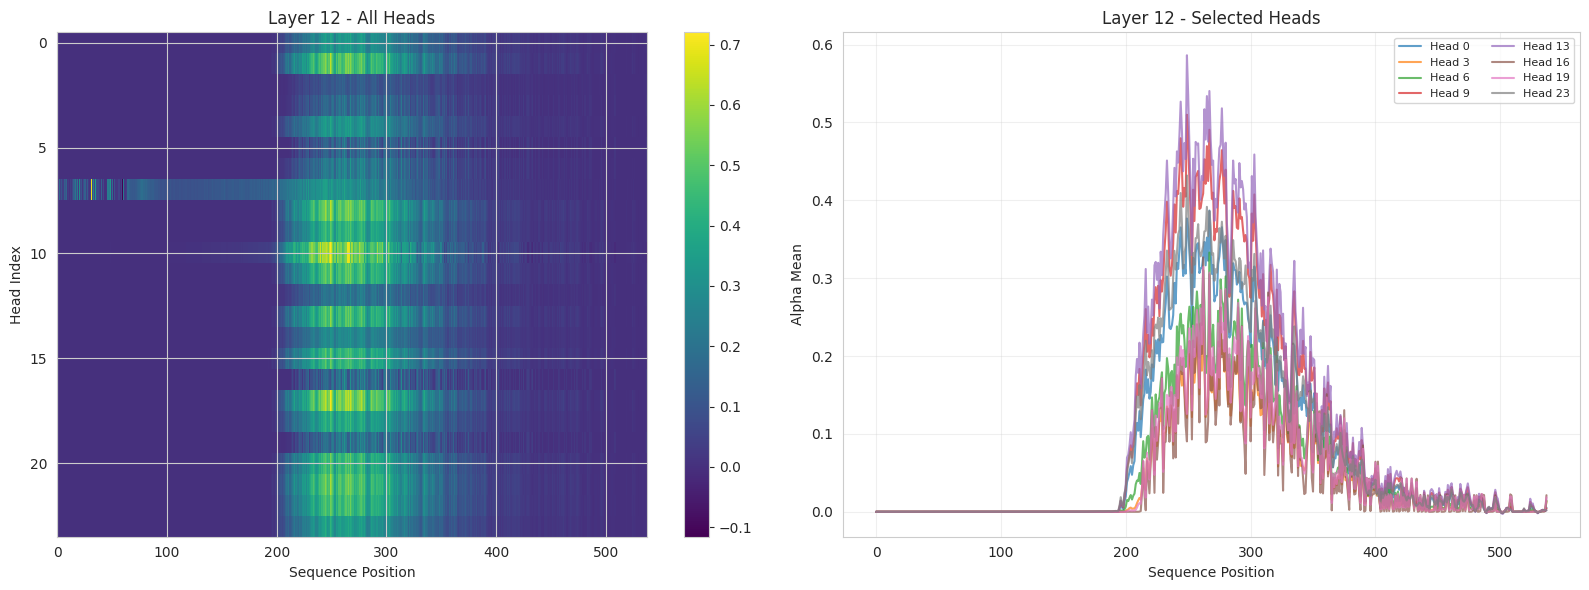

Saved: ./experiments/alpha_stats_full_05120827_multihead_layer12.png


In [13]:
# Select a middle layer
target_layer = n_layer // 2
print(f"Analyzing layer {target_layer}")

# Get data for this layer: [seqlen, nheads, headdim]
layer_alpha = alpha_mean[target_layer].numpy()
layer_alpha_avg = layer_alpha.mean(axis=-1)  # [seqlen, nheads]

# Plot heatmap showing all heads
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap: heads vs sequence position
im = axes[0].imshow(layer_alpha_avg.T, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Sequence Position')
axes[0].set_ylabel('Head Index')
axes[0].set_title(f'Layer {target_layer} - All Heads')
plt.colorbar(im, ax=axes[0])

# Select some heads to plot as lines
heads_to_plot = np.linspace(0, nheads-1, min(8, nheads), dtype=int)
for head in heads_to_plot:
    axes[1].plot(layer_alpha_avg[:, head], label=f'Head {head}', alpha=0.7)

axes[1].set_xlabel('Sequence Position')
axes[1].set_ylabel('Alpha Mean')
axes[1].set_title(f'Layer {target_layer} - Selected Heads')
axes[1].legend(fontsize=8, ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_multihead_layer{target_layer}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_multihead_layer{target_layer}.png")

## 7. Layer-wise Statistics

Analyze how attention patterns evolve across layers.

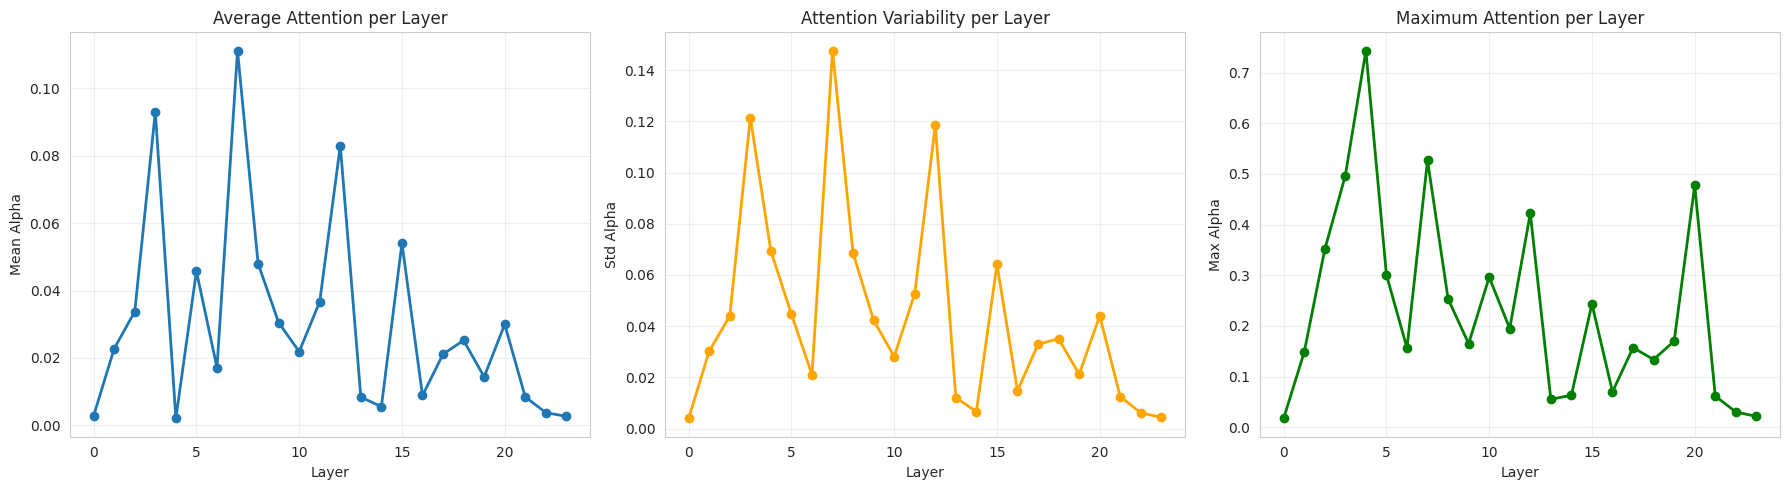

Saved: ./experiments/alpha_stats_full_05120827_layer_statistics.png


In [14]:
# Calculate statistics for each layer
layer_mean = alpha_overall.mean(axis=1)  # Average attention per layer
layer_std = alpha_overall.std(axis=1)    # Variability per layer
layer_max = alpha_overall.max(axis=1)    # Max attention per layer

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean attention
axes[0].plot(layer_mean, marker='o', linewidth=2)
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Mean Alpha')
axes[0].set_title('Average Attention per Layer')
axes[0].grid(True, alpha=0.3)

# Standard deviation
axes[1].plot(layer_std, marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Std Alpha')
axes[1].set_title('Attention Variability per Layer')
axes[1].grid(True, alpha=0.3)

# Max attention
axes[2].plot(layer_max, marker='o', linewidth=2, color='green')
axes[2].set_xlabel('Layer')
axes[2].set_ylabel('Max Alpha')
axes[2].set_title('Maximum Attention per Layer')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_layer_statistics.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_layer_statistics.png")

## 8. Compare Multiple doc2 Samples

Load and compare attention patterns from different doc2 samples.

In [15]:
# Load multiple files
num_files_to_compare = min(4, len(files))
selected_files = files[:num_files_to_compare]

print(f"Comparing {num_files_to_compare} doc2 samples")

# Load data from each file
all_alphas = []
doc_ids = []
for f in selected_files:
    filepath = os.path.join(output_dir, f)
    data_tmp = torch.load(filepath)
    # Average across heads and headdims: [n_layer, seqlen]
    alpha_tmp = data_tmp['alpha_mean'].mean(dim=(2, 3)).numpy()
    all_alphas.append(alpha_tmp)
    doc_ids.append(data_tmp['doc2_id'][:8])

print(f"Loaded doc2 IDs: {doc_ids}")

Comparing 4 doc2 samples
Loaded doc2 IDs: ['5a7bb131', '5ae03a36', '5ab77e66', '5ab67b71']


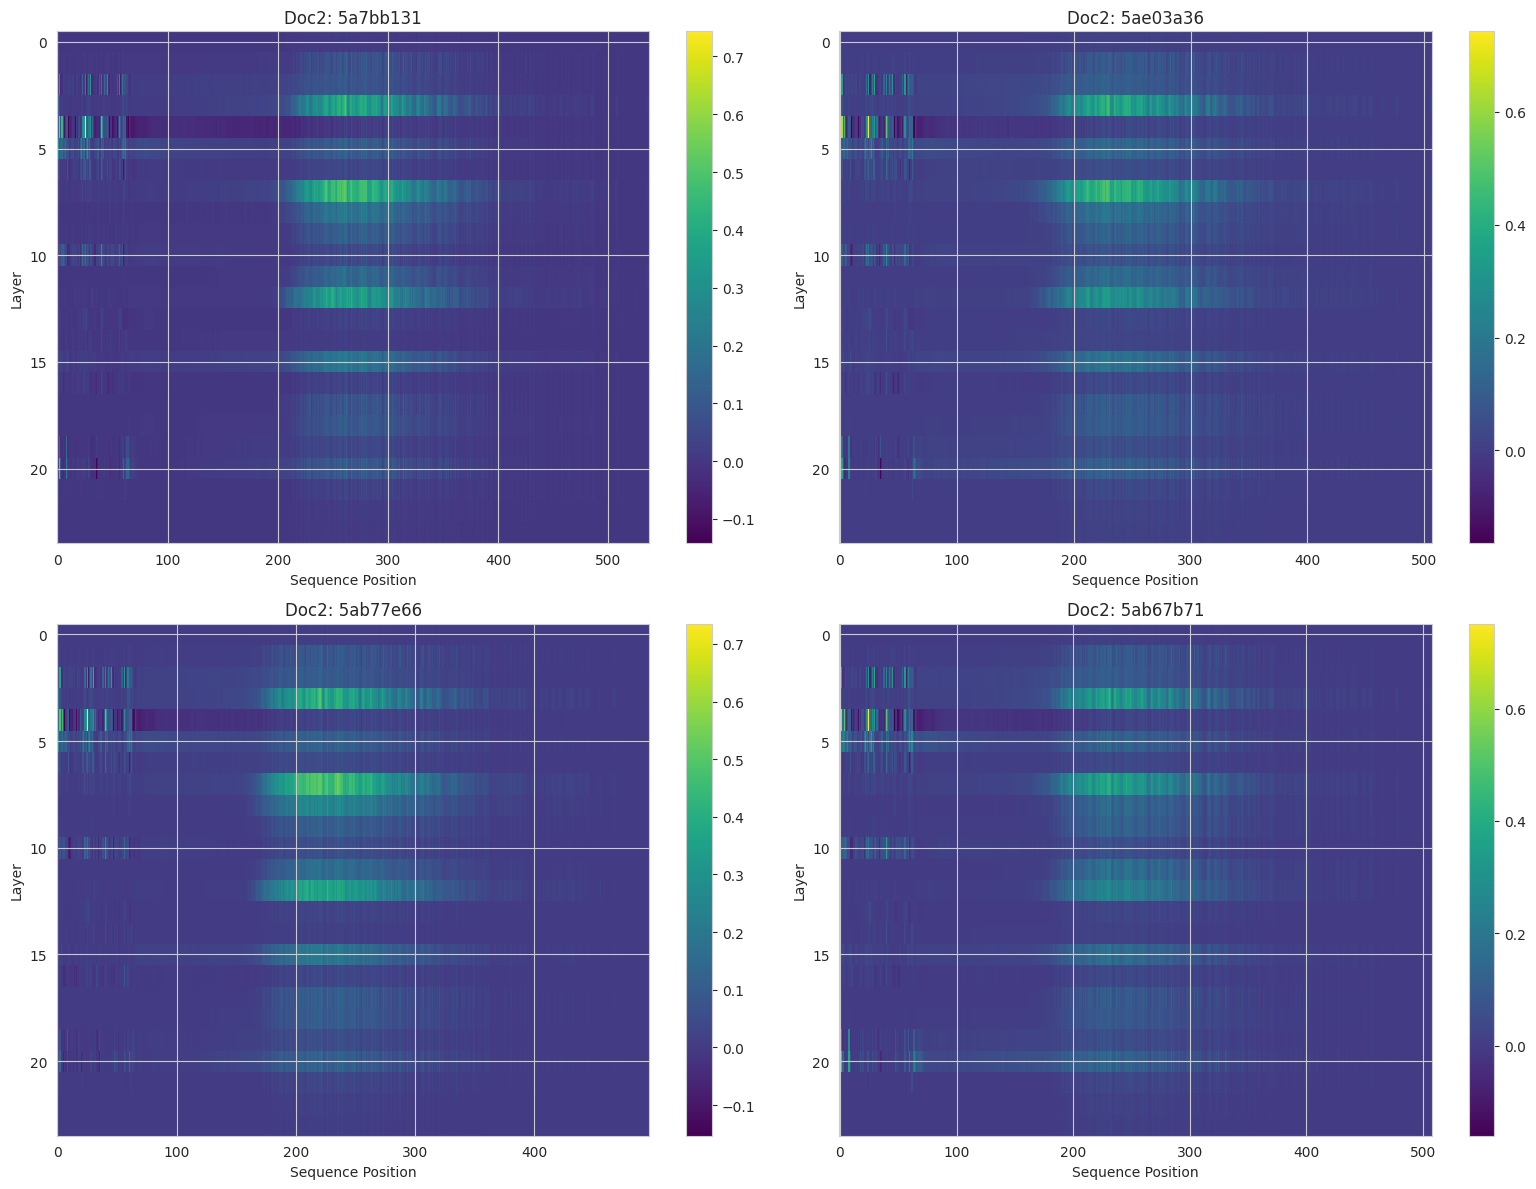

Saved: ./experiments/alpha_stats_full_05120827_doc2_comparison.png


In [16]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (alpha_data, doc_id) in enumerate(zip(all_alphas, doc_ids)):
    im = axes[idx].imshow(alpha_data, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[idx].set_xlabel('Sequence Position')
    axes[idx].set_ylabel('Layer')
    axes[idx].set_title(f'Doc2: {doc_id}')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.savefig(f'{output_dir}_doc2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_doc2_comparison.png")

## 9. Summary Statistics

In [ ]:
print("=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"\nExperiment: {output_dir}")
print(f"Number of doc2 samples: {len(files)}")
print(f"\nFirst sample:")
print(f"  Doc2 ID: {data['doc2_id']}")
print(f"  Number of doc1 paired: {data['num_doc1_samples']}")
print(f"  Max doc2 length: {data.get('max_doc2_len', data.get('max_seqlen', 'N/A'))}")
print(f"  Model architecture: {data['n_layer']} layers, {data['nheads']} heads, {data['headdim']} headdim")
print(f"\nAlpha statistics:")
print(f"  Mean range: [{alpha_mean.min():.4f}, {alpha_mean.max():.4f}]")
print(f"  Mean average: {alpha_mean.mean():.4f}")
print(f"  Variance range: [{alpha_var.min():.4f}, {alpha_var.max():.4f}]")
print(f"  Variance average: {alpha_var.mean():.4f}")
if 'note' in data:
    print(f"\nNote: {data['note']}")
print("\n" + "=" * 70)